In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df=pd.read_csv('data_v1/df_final.csv')

In [4]:
latest_stops_df = df.loc[df.groupby(["raceId", "driverId", "constructorId"])["stop"].idxmax()]

In [5]:
latest_stops_df.to_csv('data_v1/latest_stops_df.csv', index=False)

In [6]:
latest_stops_df.rename(columns={'stop':'numStops'}, inplace=True)


In [7]:
latest_stops_df.drop(['lap','milliseconds'],axis=1,inplace=True)

In [8]:
#position=1 as 1 else 0
latest_stops_df['positionOrder'] = latest_stops_df['positionOrder'].apply(lambda x: 1 if x==1 else 0)

In [9]:
latest_stops_df['positionOrder'].sum()

273

In [10]:
latest_stops_df.drop(['raceId'],axis=1,inplace=True)

In [11]:
latest_stops_df.to_csv('data_v1/latest_stops_df1.csv', index=False)

In [12]:
latest_stops_df.head()

,driverId,constructorId,grid,positionOrder,laps,circuitId,numStops
3,1,1,2,0,58,1,2
28,2,4,18,0,57,1,2
38,3,131,7,0,22,1,1
8,4,6,5,0,58,1,3
39,5,205,19,0,19,1,1


In [13]:
latest_stops_train = latest_stops_df.drop(['positionOrder'],axis=1)
latest_stops_target = latest_stops_df['positionOrder']

In [14]:
from sklearn.model_selection import train_test_split
x1_train, x1_test, y1_train, y1_test = train_test_split(latest_stops_train, latest_stops_target, test_size=0.2, random_state=42)   

In [15]:
#one hot encoding of drverID, constructorId, circuitId
df_training = pd.get_dummies(latest_stops_df, columns=['driverId','constructorId','circuitId'])

In [16]:
df_training.to_csv('data_v1/df_training.csv', index=False)

In [17]:
from sklearn.model_selection import train_test_split
X = df_training.drop(['positionOrder'], axis=1)
Y = df_training['positionOrder']

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [69]:
X_train['numStops']

7482     1
8111     4
10029    2
361      1
7585     2
        ..
6682     1
7804     2
10694    4
10746    1
2022     3
Name: numStops, Length: 4276, dtype: int64

In [19]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


(4276, 135)
(1070, 135)
(4276,)
(1070,)


In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

logreg = LogisticRegression(class_weight='balanced',max_iter=1000)
logreg.fit(X_train, Y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [95]:
y_pred_train=(logreg.predict_proba(X_train)[:,1] >= 0.8).astype(bool)

print(classification_report(Y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      4059
           1       0.41      0.77      0.54       217

    accuracy                           0.93      4276
   macro avg       0.70      0.86      0.75      4276
weighted avg       0.96      0.93      0.94      4276



In [103]:
print("Results of Logistic Regression Model on Test Data") 
y_pred=logreg.predict_proba(X_test)[:,1] >= 0.5
print(classification_report(Y_test, y_pred))

Results of Logistic Regression Model on Test Data
              precision    recall  f1-score   support

           0       1.00      0.86      0.92      1014
           1       0.27      0.93      0.42        56

    accuracy                           0.87      1070
   macro avg       0.63      0.90      0.67      1070
weighted avg       0.96      0.87      0.90      1070



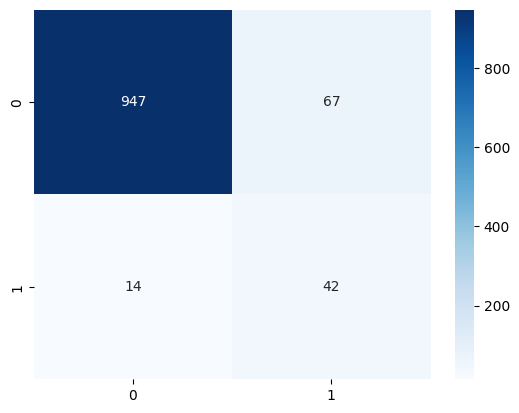

In [97]:
cm=confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');

In [25]:
#K fold and plot the curves for all folds
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score

kfold = KFold(n_splits=5, random_state=42, shuffle=True)
cv_results = cross_val_score(logreg, X_train, Y_train, cv=kfold, scoring='f1')
print(cv_results)


[0.40659341 0.42156863 0.41530055 0.39106145 0.42553191]


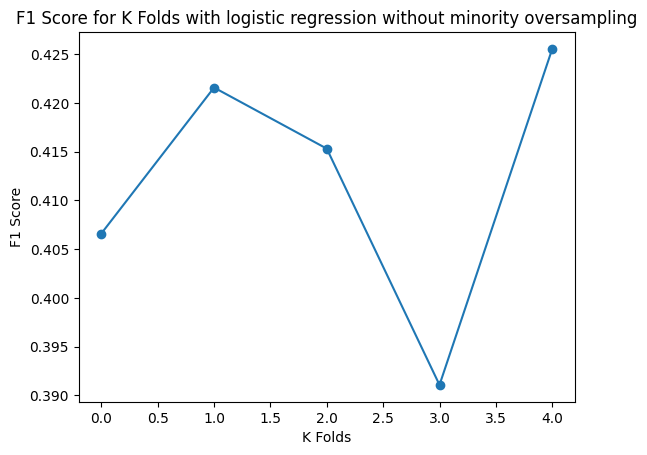

In [26]:
plt.plot(cv_results, marker='o')
plt.xlabel('K Folds')
plt.ylabel('F1 Score')
plt.title('F1 Score for K Folds with logistic regression without minority oversampling')
plt.show()

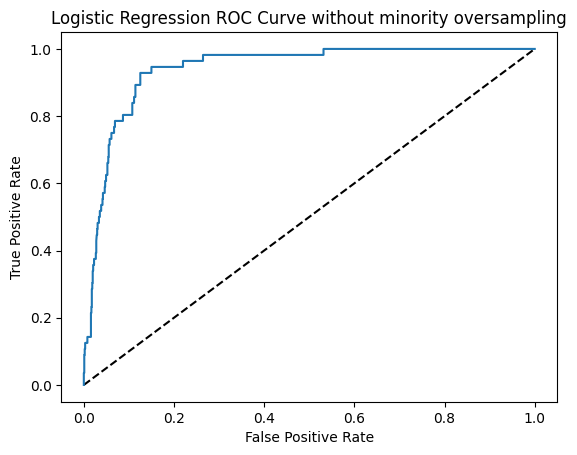

In [27]:
#plot the ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve without minority oversampling')
plt.show()


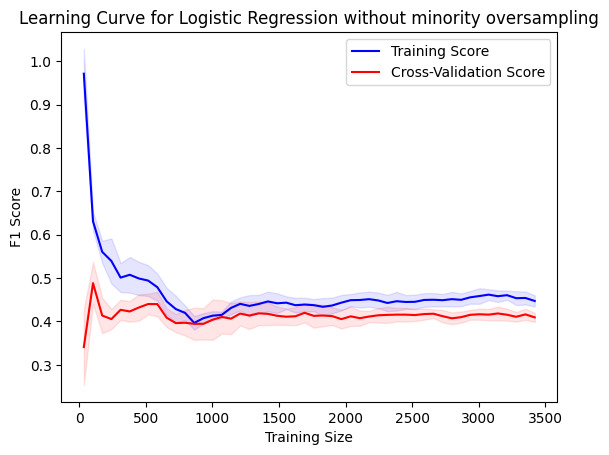

In [28]:
#plot bias variance tradeoff
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(logreg, X_train, Y_train, cv=kfold, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, color='blue', alpha=0.1)
plt.plot(train_sizes, test_mean, label='Cross-Validation Score', color='red')
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, color='red', alpha=0.1)
plt.title('Learning Curve for Logistic Regression without minority oversampling')
plt.xlabel('Training Size')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [29]:
#xg
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, Y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [30]:
y_pred_train=xgb.predict(X_train)

print(classification_report(Y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4059
           1       0.88      0.75      0.81       217

    accuracy                           0.98      4276
   macro avg       0.93      0.87      0.90      4276
weighted avg       0.98      0.98      0.98      4276



              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1014
           1       0.60      0.43      0.50        56

    accuracy                           0.96      1070
   macro avg       0.78      0.71      0.74      1070
weighted avg       0.95      0.96      0.95      1070



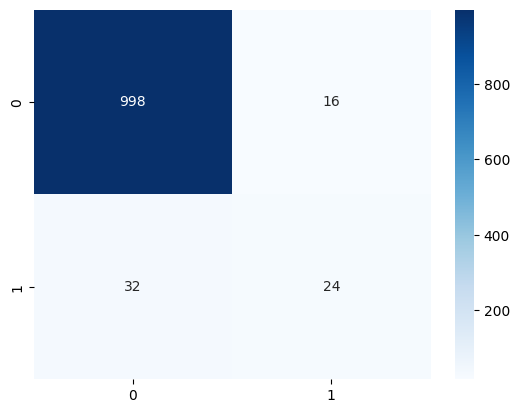

In [31]:
y_pred=xgb.predict(X_test)

print(classification_report(Y_test, y_pred))

cm=confusion_matrix(Y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');

In [32]:
# smote
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)


In [ ]:
lr=LogisticRegression(class_weight='balanced',max_iter=1000)
lr.fit(X_train_smote, Y_train_smote)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [105]:
y_pred_train=lr.predict(X_train_smote)

print(classification_report(Y_train_smote, y_pred_train))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      4059
           1       0.96      0.97      0.97      4059

    accuracy                           0.97      8118
   macro avg       0.97      0.97      0.97      8118
weighted avg       0.97      0.97      0.97      8118



[0.95255474 0.95772947 0.96539379 0.96258719 0.97039275]


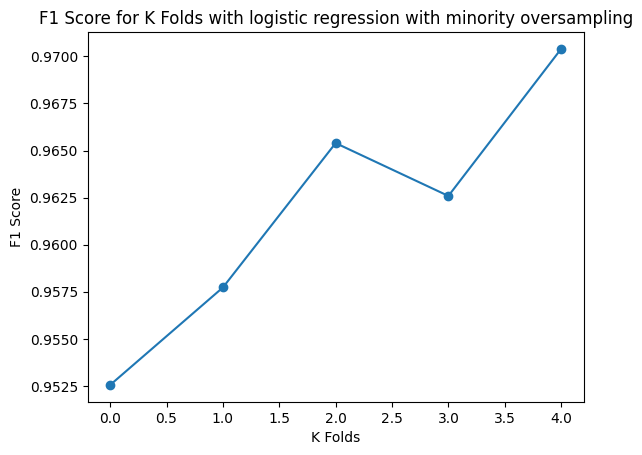

In [36]:
# K fold and plot the curves for all folds
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict

kfold = KFold(n_splits=5, random_state=42, shuffle=True)
cv_results = cross_val_score(lr, X_train_smote, Y_train_smote, cv=kfold, scoring='f1')
print(cv_results)

plt.plot(cv_results, marker='o')
plt.xlabel('K Folds')
plt.ylabel('F1 Score')
plt.title('F1 Score for K Folds with logistic regression with minority oversampling')
plt.show()

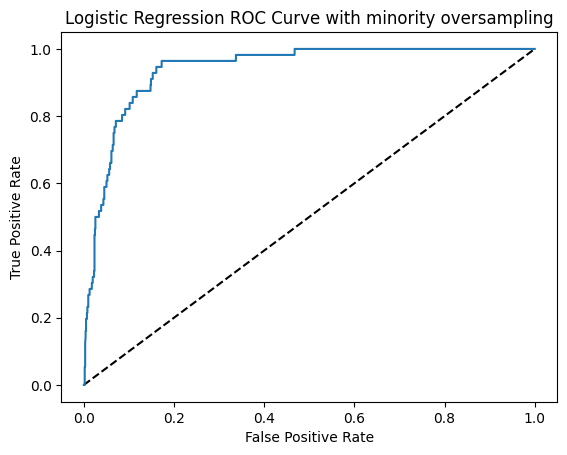

In [37]:
# plot the ROC curve
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_prob = lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve with minority oversampling')
plt.show()


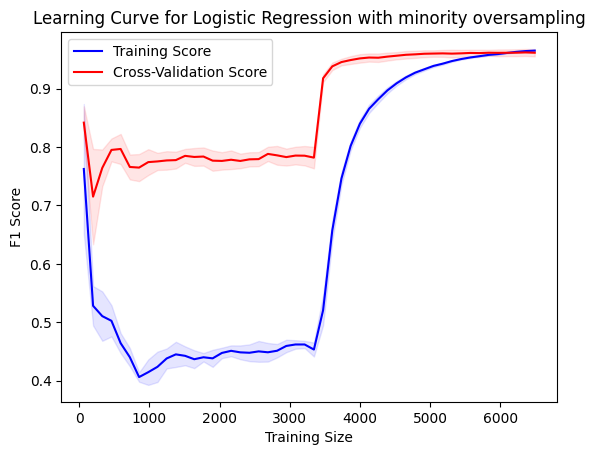

In [38]:
# plot bias variance tradeoff
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(lr, X_train_smote, Y_train_smote, cv=kfold, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.plot(train_sizes, test_mean, label='Cross-Validation Score', color='red')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.1)
plt.title('Learning Curve for Logistic Regression with minority oversampling')

plt.xlabel('Training Size')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [104]:
print("Results of Logistic Regression Model with SMOTE on Test Data")
y_pred=lr.predict(X_test)

print(classification_report(Y_test, y_pred))

Results of Logistic Regression Model with SMOTE on Test Data
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1014
           1       0.38      0.64      0.48        56

    accuracy                           0.93      1070
   macro avg       0.68      0.79      0.72      1070
weighted avg       0.95      0.93      0.94      1070



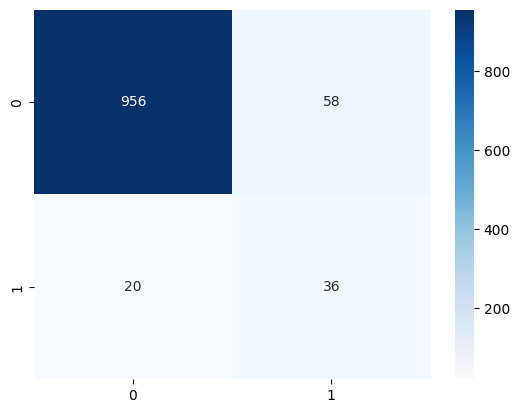

In [106]:
cm=confusion_matrix(Y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');

In [41]:
#K fold
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr, X_train, Y_train, cv=5, scoring='f1')

In [42]:
#xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train_smote, Y_train_smote)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [43]:

y_pred_train=xgb.predict(X_train_smote)

print(classification_report(Y_train_smote, y_pred_train))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4059
           1       0.98      0.99      0.99      4059

    accuracy                           0.99      8118
   macro avg       0.99      0.99      0.99      8118
weighted avg       0.99      0.99      0.99      8118



In [44]:
y_pred=xgb.predict(X_test)

print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1014
           1       0.45      0.57      0.50        56

    accuracy                           0.94      1070
   macro avg       0.71      0.77      0.74      1070
weighted avg       0.95      0.94      0.94      1070



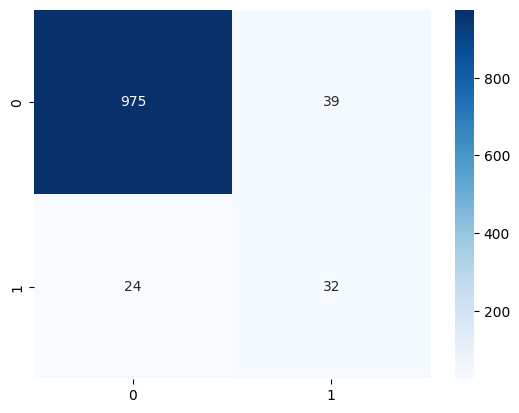

In [45]:
cm=confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');

In [46]:
#random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100)
rf.fit(X_train, Y_train)

y_pred_train=rf.predict(X_train)

print(classification_report(Y_train, y_pred_train))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4059
           1       0.92      1.00      0.95       217

    accuracy                           1.00      4276
   macro avg       0.96      1.00      0.98      4276
weighted avg       1.00      1.00      1.00      4276



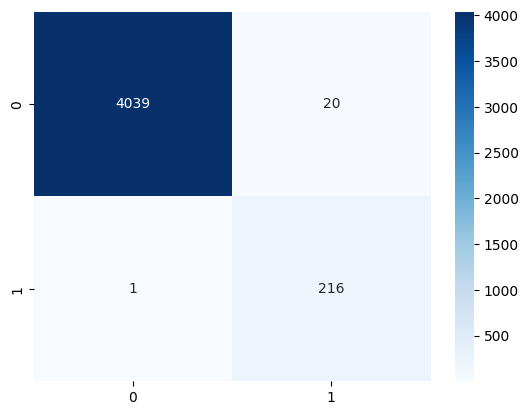

In [47]:
cm=confusion_matrix(Y_train, y_pred_train)
sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1014
           1       0.53      0.38      0.44        56

    accuracy                           0.95      1070
   macro avg       0.75      0.68      0.71      1070
weighted avg       0.94      0.95      0.95      1070



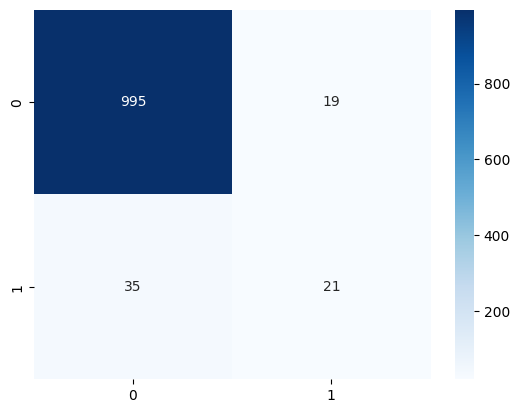

In [48]:
y_pred=rf.predict(X_test)

print(classification_report(Y_test, y_pred))

cm=confusion_matrix(Y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');

In [49]:

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000)
mlp.fit(X_train, Y_train)



MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000)

In [50]:
y_pred_train=mlp.predict(X_train)

print(classification_report(Y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4059
           1       0.69      0.46      0.55       217

    accuracy                           0.96      4276
   macro avg       0.83      0.72      0.77      4276
weighted avg       0.96      0.96      0.96      4276



              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1014
           1       0.55      0.41      0.47        56

    accuracy                           0.95      1070
   macro avg       0.76      0.70      0.72      1070
weighted avg       0.95      0.95      0.95      1070



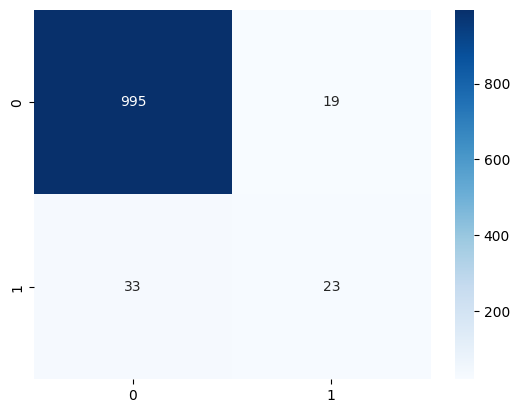

In [51]:
y_pred=mlp.predict(X_test)

print(classification_report(Y_test, y_pred))

cm=confusion_matrix(Y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');

In [52]:
#random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100)


In [53]:
rf.fit(x1_train, y1_train)

RandomForestClassifier(class_weight='balanced')

In [54]:
y_pred_train=rf.predict(x1_train)

print(classification_report(y1_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4059
           1       0.91      1.00      0.95       217

    accuracy                           0.99      4276
   macro avg       0.95      1.00      0.97      4276
weighted avg       1.00      0.99      0.99      4276



              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1014
           1       0.51      0.36      0.42        56

    accuracy                           0.95      1070
   macro avg       0.74      0.67      0.70      1070
weighted avg       0.94      0.95      0.94      1070



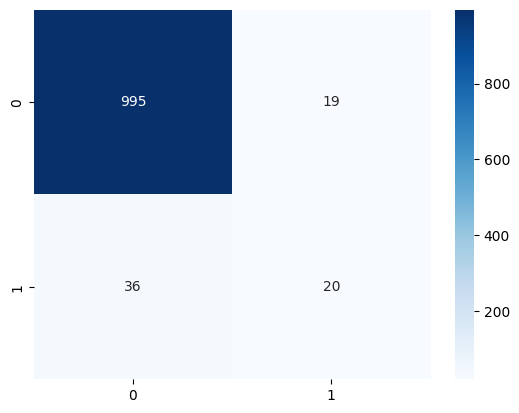

In [55]:
y_pred=rf.predict(x1_test)

print(classification_report(y1_test, y_pred))

cm=confusion_matrix(y1_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');

In [56]:
#svm 
from sklearn.svm import SVC
svc = SVC(class_weight='balanced', kernel='linear')
svc.fit(X_train, Y_train)



SVC(class_weight='balanced', kernel='linear')

In [57]:
y_pred_train=svc.predict(X_train)

print(classification_report(Y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92      4059
           1       0.26      0.96      0.41       217

    accuracy                           0.86      4276
   macro avg       0.63      0.91      0.67      4276
weighted avg       0.96      0.86      0.90      4276



              precision    recall  f1-score   support

           0       1.00      0.85      0.92      1014
           1       0.25      0.95      0.40        56

    accuracy                           0.85      1070
   macro avg       0.63      0.90      0.66      1070
weighted avg       0.96      0.85      0.89      1070



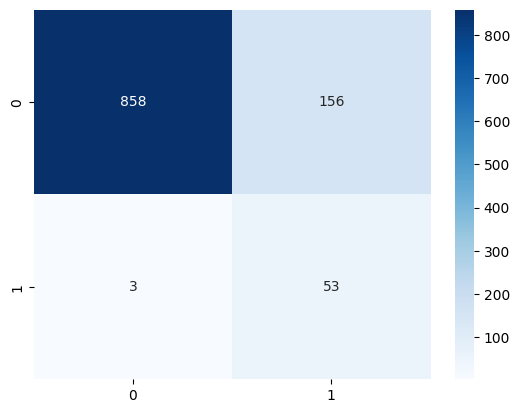

In [58]:
y_pred=svc.predict(X_test)

print(classification_report(Y_test, y_pred))

cm=confusion_matrix(Y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');

In [59]:
svc1=SVC(class_weight='balanced', kernel='rbf')
svc1.fit(X_train, Y_train)

SVC(class_weight='balanced')

In [60]:
y_pred_train=svc1.predict(X_train)

print(classification_report(Y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      0.79      0.88      4059
           1       0.19      0.93      0.32       217

    accuracy                           0.80      4276
   macro avg       0.59      0.86      0.60      4276
weighted avg       0.95      0.80      0.85      4276



              precision    recall  f1-score   support

           0       0.99      0.78      0.88      1014
           1       0.19      0.93      0.32        56

    accuracy                           0.79      1070
   macro avg       0.59      0.86      0.60      1070
weighted avg       0.95      0.79      0.85      1070



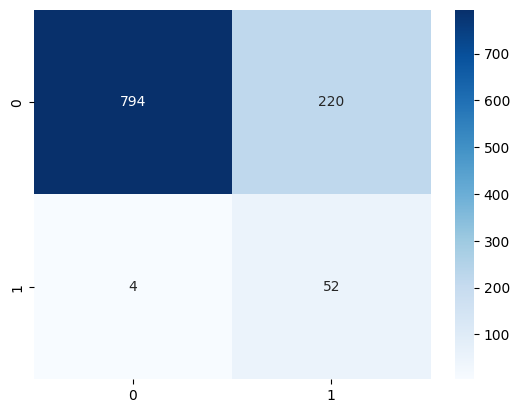

In [61]:
y_pred=svc1.predict(X_test)

print(classification_report(Y_test, y_pred))

cm=confusion_matrix(Y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');

In [62]:
#passive agressive classifier
from sklearn.linear_model import PassiveAggressiveClassifier

pac = PassiveAggressiveClassifier(max_iter=1000,class_weight='balanced')
pac.fit(X_train, Y_train)



PassiveAggressiveClassifier(class_weight='balanced')

In [63]:


y_pred_train=pac.predict(X_train)

print(classification_report(Y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4059
           1       0.54      0.42      0.47       217

    accuracy                           0.95      4276
   macro avg       0.75      0.70      0.72      4276
weighted avg       0.95      0.95      0.95      4276



              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1014
           1       0.53      0.41      0.46        56

    accuracy                           0.95      1070
   macro avg       0.75      0.70      0.72      1070
weighted avg       0.95      0.95      0.95      1070



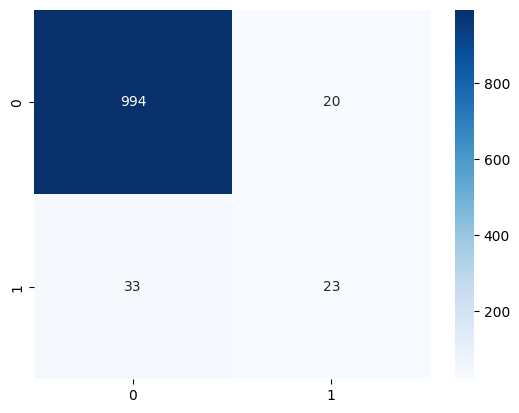

In [64]:
y_pred=pac.predict(X_test)

print(classification_report(Y_test, y_pred))

cm=confusion_matrix(Y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');

In [66]:
#decision tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(class_weight='balanced')
dt.fit(X_train, Y_train)




DecisionTreeClassifier(class_weight='balanced')

In [67]:
y_pred_train=dt.predict(X_train)

print(classification_report(Y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4059
           1       0.91      1.00      0.95       217

    accuracy                           0.99      4276
   macro avg       0.95      1.00      0.97      4276
weighted avg       1.00      0.99      0.99      4276



              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1014
           1       0.34      0.43      0.38        56

    accuracy                           0.93      1070
   macro avg       0.66      0.69      0.67      1070
weighted avg       0.94      0.93      0.93      1070



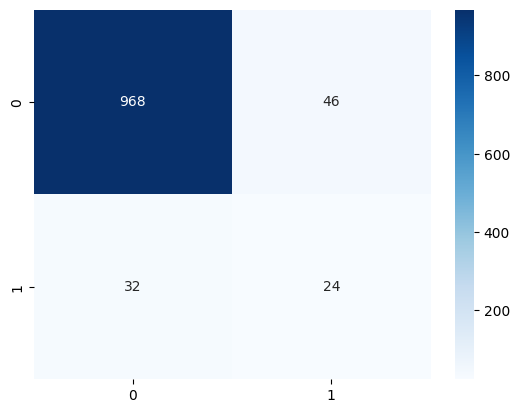

In [68]:
y_pred=dt.predict(X_test)

print(classification_report(Y_test, y_pred))

cm=confusion_matrix(Y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');

In [70]:
def align_features(X_train, new_input):
    """
    Align new input features with the training feature space.
    Missing columns will be filled with 0.
    """
    # Identify missing columns between the training and new input
    missing_cols = list(set(X_train.columns) - set(new_input.columns))
    
    # Add missing columns (initialized with 0)
    missing_df = pd.DataFrame(0, index=new_input.index, columns=missing_cols)

    # Combine the original input with the missing columns
    aligned_input = pd.concat([new_input, missing_df], axis=1)

    # Ensure the order of columns matches the training data
    aligned_input = aligned_input[X_train.columns]

    return aligned_input

In [98]:
new_race = {
    'grid': [2,1,6,5,7,12,8,13,10,11,18,3,16,15,21,22,17,20,14,9,19,4],
    'laps': [57] * 22,  # Same laps for all drivers
    'circuitId_3': [1] * 22,  # Circuit ID 3 for all drivers
    'numStops': [1]*22
}

# One-hot encode driver and constructor IDs
drivers = [13,9,2,5,15,17,3,10,4,22,21,1,6,7,19,11,14,16,12,18,20,8]
constructors = [6,2,2,1,7,9,3,7,4,11,10,1,3,5,8,8,9,10,4,11,5,6]

# Add one-hot encoded driver and constructor columns
for driver in drivers:
    new_race[f'driverId_{driver}'] = [1 if i == drivers.index(driver) else 0 for i in range(22)]

for constructor in constructors:
    new_race[f'constructorId_{constructor}'] = [1 if i == constructors.index(constructor) else 0 for i in range(22)]


new_race_df = pd.DataFrame(new_race)


aligned_input = align_features(X_train, new_race_df)

# print(aligned_input)
predictions = lr.predict(aligned_input)

print(predictions)
winner_index = predictions.argmax()  
winning_driver = drivers[winner_index]

proba = lr.predict_proba(aligned_input)

for driver, prob in zip(drivers, proba):
    print(f"Driver ID: {driver}, Probability: {prob[1]:.2f}")

#use max probability to predict winner
for driver, prob in zip(drivers, proba):
    if prob[1] == max(proba[:,1]):
        winning_driver = driver
print(f"Predicted winner: {winning_driver}")

[0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1]
Driver ID: 13, Probability: 0.41
Driver ID: 9, Probability: 0.99
Driver ID: 2, Probability: 0.90
Driver ID: 5, Probability: 0.37
Driver ID: 15, Probability: 0.87
Driver ID: 17, Probability: 0.01
Driver ID: 3, Probability: 0.01
Driver ID: 10, Probability: 0.26
Driver ID: 4, Probability: 0.03
Driver ID: 22, Probability: 0.49
Driver ID: 21, Probability: 0.00
Driver ID: 1, Probability: 0.95
Driver ID: 6, Probability: 0.08
Driver ID: 7, Probability: 0.01
Driver ID: 19, Probability: 0.01
Driver ID: 11, Probability: 0.00
Driver ID: 14, Probability: 0.05
Driver ID: 16, Probability: 0.01
Driver ID: 12, Probability: 0.18
Driver ID: 18, Probability: 0.48
Driver ID: 20, Probability: 0.01
Driver ID: 8, Probability: 0.60
Predicted winner: 9


In [99]:
import joblib
joblib.dump(lr, 'lr_model.pkl')

['lr_model.pkl']

In [101]:
import joblib
#load
lr = joblib.load('lr_model.pkl')

#predict probability
proba = lr.predict_proba(aligned_input)

for driver, prob in zip(drivers, proba):
    print(f"Driver ID: {driver}, Probability: {prob[1]:.2f}")

#use max probability to predict winner

for driver, prob in zip(drivers, proba):
    if prob[1] == max(proba[:,1]):
        winning_driver = driver

print(f"Predicted winner: {winning_driver}")

Driver ID: 13, Probability: 0.41
Driver ID: 9, Probability: 0.99
Driver ID: 2, Probability: 0.90
Driver ID: 5, Probability: 0.37
Driver ID: 15, Probability: 0.87
Driver ID: 17, Probability: 0.01
Driver ID: 3, Probability: 0.01
Driver ID: 10, Probability: 0.26
Driver ID: 4, Probability: 0.03
Driver ID: 22, Probability: 0.49
Driver ID: 21, Probability: 0.00
Driver ID: 1, Probability: 0.95
Driver ID: 6, Probability: 0.08
Driver ID: 7, Probability: 0.01
Driver ID: 19, Probability: 0.01
Driver ID: 11, Probability: 0.00
Driver ID: 14, Probability: 0.05
Driver ID: 16, Probability: 0.01
Driver ID: 12, Probability: 0.18
Driver ID: 18, Probability: 0.48
Driver ID: 20, Probability: 0.01
Driver ID: 8, Probability: 0.60
Predicted winner: 9
